# Bach Figured bass analysis

## Done
- Got a countvectorized representation

## TO DO:
- The countvectorized_data includes only n-grams of figuration. Next, combine figuration and bass movement counted in half-step (e.g. +2, -1, etc...)
    - When I create the string I can a word in between figure bass to describe the bass motion. Then I would copute the n-grams only for odd numbers. e.g. RO would be: !6! [+2] !6 5!
    - the ! are rather ugly, better use [] and {}

In [50]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import seaborn as sns
import re

In [51]:
filename = "../Data/Music/Figured_bass/Bach_chorale_FB-master/FB_source/translated_kern/" + "BWV_10.07a_FB.musicxml.krn"
part_types = pd.read_csv(filename, 
                     skiprows=3, sep='\t',nrows=0)
df = pd.read_csv(filename, 
                     skiprows=13, names=['cont','fb'],
                     sep='\t', usecols = [0, np.argwhere(part_types.columns=='**fb').flatten()[0]],
                     )
df.head()

# compute distance


,cont,fb
0,2G,.
1,2A,6
2,=3,=3
3,4B-,5
4,4A,#6\ 4 3


# Parsing the notes strings

The Humdrum language is notation [here](https://www.humdrum.org/guide/ch02/).

        


In [152]:
def get_note_degree(s):
    # s is a string containing a single line of Humdrum notation representation a note (. and measure numbering should be avoided)
    # assign a number to each note (in half-step), counting from C0 
    shift_dict = {'C':0, 'D':2, 'E':4, 'F':5, 'G':7, 'A':9, 'B':11}
    m = re.search('[A-Ga-g\.]+[\#\-n]*', s)
    s1 = m.group(0)
    
    m = re.search('[A-Ga-g\.]+', s1)
    s3 = m.group(0)
    
    m = re.search('[\#]+', s1)
    sharps = m.group(0) if m else ""
    
    m = re.search('[\-]+', s1)
    flats = m.group(0) if m else ""
    
    
    octave = 4 + len(s3)-1   if s3[0].islower()   else 4 - len(s3)
    
    
    num = octave*12 + shift_dict[s3[0].upper()] + len(sharps) - len(flats)
#     print(f"{s:<10}  {s1: <10} {s2: <5} {s3: <5} {sharps: <5} {flats: <5} {num:.0f}")
    return num

In [183]:
def import_and_clean(filename):
    part_types = pd.read_csv(filename, 
                     skiprows=3, sep='\t',nrows=0)
#     part_names = pd.read_csv(filename, 
#                      skiprows=6, sep='\t',nrows=0)    
    col_number_fb = np.argwhere(part_types.columns=='**fb').flatten()[0]
    df = pd.read_csv(filename, 
                     skiprows=13, names=['cont','fb'],
                     sep='\t', usecols = [col_number_fb-1,
                                          col_number_fb],
                     )
    # Drop rows corresponding to:
    # bar number 
    list_drop = ["=", "\.", "r", "\*"]
    for drop_string in list_drop:
#         print(drop_string)
        df.drop(index=np.argwhere(df.loc[:,'cont'].str.contains(drop_string).values).flatten(),inplace=True)
        df.reset_index(inplace=True,drop=True)
    
    # I might not want to drop those eventually, but right now I'm not sure how to handle it
#     df.drop(index=np.argwhere(df.loc[:,'fb'].str.contains("\.").values).flatten(),inplace=True)
#     df.reset_index(inplace=True,drop=True)
    
    df.drop(index=df.index[-2:], inplace=True)

    
    # convert to a string
    fb = list(df['fb'].values)
    cont = list(df['cont'].values)
    string = ''
    for i, (s_fb, s_cont) in enumerate(zip(fb, cont)):
        this_string = f"[{s_fb}]"
#         print(s_cont)
        this_degree = get_note_degree(s_cont)
        if i>0:
            mvt = this_degree - old_degree
            mvt_string = f'{mvt:.0f}'
            string += " {" + mvt_string + "} "
        
        string += this_string
        old_degree = this_degree
        
    return string

In [184]:
basefolder = "../Data/Music/Figured_bass/Bach_chorale_FB-master/FB_source/translated_kern/"
string_dict = {}
for file in listdir(basefolder):
# for file in ["BWV_171.06_FB.musicxml.krn"]:
#     print(file)
    if file[-4:] == '.krn':
        string_dict[file[:-15]] = import_and_clean(basefolder + file)

df = pd.DataFrame.from_dict(string_dict,orient='index',columns=['fb'])
df.head()

,fb
BWV_13.06_,[.] {-1} [.] {-2} [6] {-2} [.] {-1} [6] {-2} [...
BWV_174.05_,[5] {2} [6] {2} [6 5] {1} [4] {-7} [9] {2} [.]...
BWV_251_,[6] {-2} [.] {-2} [6] {5} [5] {2} [nr6] {2} [6...
BWV_244.32_,[.] {-2} [5] {-5} [5] {7} [6] {1} [4] {0} [6 4...
BWV_248.42_,[.] {-1} [.] {1} [.] {4} [.] {-2} [.] {2} [.] ...


# TfIdf

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(token_pattern=r"\[[^\[\]]+\]")
# vectorizer = TfidfVectorizer(token_pattern=r"\[[^\[\]]+\] \{[^\{\}]+\} \[[^\[\]]+\]")
vectorizer = TfidfVectorizer(token_pattern=r"\[[^\[\]]+\]|\{[^\{\}]+\}")
vectorized_data = vectorizer.fit_transform(df['fb'])

print(vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names(),index=df.index)

tfidf_df.head()

['[ ]', '[# 7]', '[#4| 2]', '[#4| 6]', '[#4|]', '[#5\\ #]', '[#5\\ 4]', '[#5\\]', '[#5| #]', '[#5| 4 9]', '[#5| 4]', '[#5|]', '[#6\\ #4| 3]', '[#6\\ -r5]', '[#6\\ 4 3]', '[#6\\ 4]', '[#6\\ 5]', '[#6\\ n]', '[#6\\ nr5]', '[#6\\]', '[#7\\ 4 2]', '[#7\\ 4]', '[#7\\ 5]', '[#7\\]', '[#7| 5 4]', '[#7| 7]', '[#7|]', '[#]', '[#_]', '[#r5]', '[#r6 #4| 2]', '[#r6 5]', '[#r7]', '[-]', '[-r4]', '[-r5]', '[-r6 4 -r2]', '[-r6 4 2]', '[-r6 4]', '[-r6]', '[-r7 3]', '[-r7 5]', '[-r7]', '[..]', '[.]', '[._]', '[2 nr4 6]', '[2]', '[3 5]', '[3 6 #4|]', '[3 6]', '[3 7]', '[3]', '[4 #2\\]', '[4 #7| 5]', '[4 2 5]', '[4 2]', '[4 5 2]', '[4 5]', '[4 6 2]', '[4 6 8]', '[4 7]', '[4 9 #7\\]', '[4 9]', '[4]', '[5 #2|]', '[5 #6\\]', '[5 #]', '[5 -]', '[5 -r4 2]', '[5 2]', '[5 3]', '[5 4 #2|]', '[5 4 -r2]', '[5 4 2]', '[5 4]', '[5 6]', '[5 7]', '[5 8]', '[5 n]', '[5]', '[5_ 3_]', '[5_]', '[6 #4| #2\\]', '[6 #4| 2]', '[6 #4| 3]', '[6 #4|]', '[6 #]', '[6 -]', '[6 -r5]', '[6 3]', '[6 4 #2\\]', '[6 4 #2|]', '[6 4 -]', '

,[ ],[# 7],[#4| 2],[#4| 6],[#4|],[#5\ #],[#5\ 4],[#5\],[#5| #],[#5| 4 9],...,{21},{23},{2},{3},{4},{5},{6},{7},{8},{9}
BWV_13.06_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.309147,0.055285,0.00000,0.029098,0.0,0.040414,0.077917,0.000000
BWV_174.05_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.416866,0.000000,0.03264,0.125883,0.0,0.074932,0.000000,0.000000
BWV_251_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.510529,0.055793,0.00000,0.146826,0.0,0.000000,0.000000,0.000000
BWV_244.32_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.187508,0.000000,0.00000,0.097068,0.0,0.134819,0.000000,0.000000
BWV_248.42_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.158079,0.064784,0.04951,0.054555,0.0,0.000000,0.018261,0.017737


# Generate n-grams

In [214]:
from sklearn.feature_extraction.text import CountVectorizer

# Token for bass movement + figure
vectorizer = CountVectorizer(token_pattern=r"\[[^\[\]]+\]|\{[^\{\}]+\}",
                             ngram_range=(5,5),
                            min_df=10)

# Token for bass movement only
# vectorizer = CountVectorizer(token_pattern=r"\{[^\{\}]+\}",
#                              ngram_range=(3,5),
#                             min_df=10)


vectorized_data = vectorizer.fit_transform(df['fb'])
countvec_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names(),
                           index=df.index)
# Dismiss the n-grams that start or end with {}
countvec_df.drop(columns=countvec_df.columns[np.argwhere(countvec_df.columns.str[0]=="{").flatten()],inplace=True)
countvec_df.drop(columns=countvec_df.columns[np.argwhere(countvec_df.columns.str[0]=="}").flatten()],inplace=True)
countvec_df.head()


,[#] {-7} [.] {12} [.],[#] {-7} [.] {5} [.],[#] {5} [.] {-2} [.],[.] {-12} [.] {12} [.],[.] {-12} [.] {5} [.],[.] {-1} [.] {-2} [.],[.] {-1} [.] {-2} [6],[.] {-1} [.] {1} [.],[.] {-1} [6 5] {1} [.],[.] {-1} [6] {-2} [.],...,[6] {1} [.] {-2} [.],[6] {1} [.] {-5} [.],[6] {1} [.] {2} [.],[6] {1} [.] {2} [6],[6] {1} [6 5] {2} [.],[6] {2} [.] {1} [.],[6] {2} [.] {2} [.],[6] {2} [6 5] {1} [.],[6] {2} [6] {1} [.],[9] {2} [.] {1} [6]
BWV_13.06_,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
BWV_174.05_,0,0,0,0,0,0,0,0,1,2,...,0,0,1,0,0,1,0,0,0,0
BWV_251_,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
BWV_244.32_,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BWV_248.42_,0,0,0,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


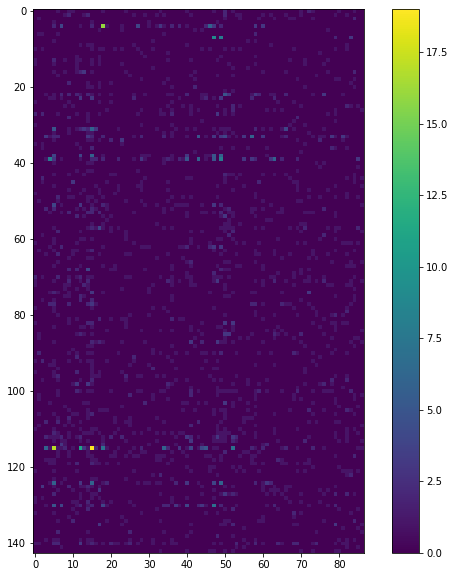

In [215]:
fig = plt.figure(figsize=[10,10])
plt.imshow(countvec_df)
plt.colorbar()

# Find the most common n-grams

<AxesSubplot:xlabel='0', ylabel='index'>

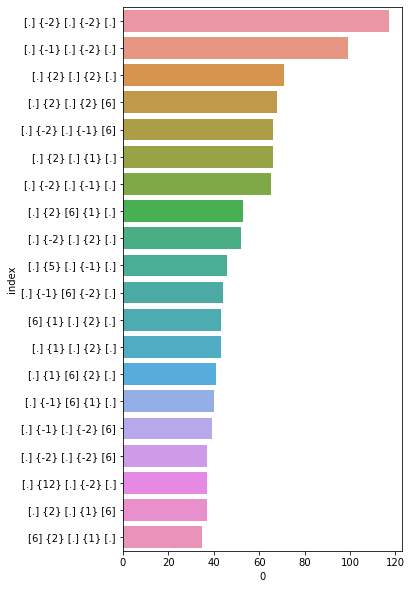

In [216]:
figure = plt.figure(figsize=[5,10])
temp = countvec_df.sum(axis=0).sort_values(ascending=False)[:20].reset_index()
temp
sns.barplot(data=temp,y='index',x=0)